<h1 style="text-align: center; color: #6A5ACD;">
Más Allá de la Predicción: Simulaciones para Entender el Abandono en Salud Mental
</h1>

<h2 style="color: #6A5ACD;">
Construcción del Dataset para Visualización en Tableau
</h2>

 Lógica:
1) Carga y selección de variables "narrativas" (legibles para negocio/salud)
2) Cálculo de retención base por cohortes
3) Construcción de escenarios A (actual) y B (intervención) con uplift
4) Exportación a CSV listo para Tableau

<h2 style="color: #6A5ACD;">
1. Configuración y librerías necesarias
</h2>

In [2]:
# Librerías
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import statsmodels.api as sm
from itertools import product
from statsmodels.stats.multitest import multipletests
from pathlib import Path

# Configuración general
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Carpetas de salida
os.makedirs("out", exist_ok=True)
os.makedirs("fig", exist_ok=True)
os.makedirs("Data", exist_ok=True)

# Función utilitaria para guardar figuras
def savefig(path):
    plt.tight_layout(); plt.savefig(path, bbox_inches="tight", dpi=150); plt.show()
        

<h2 style="color: #6A5ACD;">
2. Parámetros de simulación
</h2>

#### Nota metodológica

Los parámetros de simulación definidos a continuación provienen de los hallazgos
del Notebook_04 (Simulación A/B con modelo logit).

En dicho análisis se observaron mejoras en la retención de entre +10% y +15% 
al modificar factores clave como:
   - Historial de consultas (Consultation_History)
   - Condiciones de salud mental severas
   - Niveles altos de estrés (Stress_Level)

Para simplificar estos resultados en un dataset narrativo utilizable en Tableau,
se establecen reglas de uplift:
   - UPLIFT_BASE_PP = +10 pp: mejora promedio observada en el escenario B.
   - UPLIFT_RISK_PP = +5 pp: incremento adicional para grupos con lifestyle_risk=1,
     reflejando que los colectivos vulnerables mostraron un mayor beneficio (+15%).
   - UPLIFT_STRESS_PP = +5 pp: incremento adicional para cohortes con Stress_Level=High,
     en línea con los efectos más marcados vistos en la simulación.
   - RET_CLIP_MAX = 99.9: límite superior para evitar valores extremos irreales
     (100% de retención).

Estas reglas permiten trasladar los resultados estadísticos del Notebook_04# a un formato simplificado y comprensible para dashboards de negocio/salud.


In [3]:
UPLIFT_BASE_PP   = 10.0   # +10 puntos porcentuales para todos en B
UPLIFT_RISK_PP   = 5.0    # +5 pp extra si lifestyle_risk == 1
UPLIFT_STRESS_PP = 5.0    # +5 pp extra si Stress_Level == "High"
RET_CLIP_MAX     = 99.9   # límite superior (realista) para Retention_Rate

<h2 style="color: #6A5ACD;">
3. Cargar dataset
</h2>

In [4]:
DATA_PATH = "Data/mental_health_data_cohortes.csv"  
df = pd.read_csv(DATA_PATH)

# Resumen inicial
n_rows, n_cols = df.shape
print(f"Registros: {n_rows:,} | Columnas: {n_cols}")
display(df.head(3))
display(df.info())

Registros: 50,000 | Columnas: 26


,User_ID,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Social_Media_Usage,Diet_Quality,Smoking_Habit,Alcohol_Consumption,Medication_Usage,churn,Age_group,Sleep_group,Work_group,PA_group,SM_group,Severity_filled,work_sleep_ratio,lifestyle_risk
0,1,36,Male,Education,Australia,Yes,NaN,Yes,Low,7.6,46,8,2.2,Healthy,Regular Smoker,Regular Drinker,Yes,0,30-44,7-9h,41-55,5-8h,1-3h,Unknown,0.864662,0
1,2,48,Male,Engineering,Other,No,Low,No,Low,6.8,74,2,3.4,Unhealthy,Heavy Smoker,Social Drinker,No,0,45-59,5-7h,>70,<2h,3-5h,Low,1.554622,1
2,3,18,Prefer not to say,Sales,India,No,NaN,Yes,Medium,7.1,77,9,5.9,Healthy,Heavy Smoker,Social Drinker,No,0,18-29,7-9h,>70,>8h,>5h,Unknown,1.549296,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   User_ID                  50000 non-null  int64  
 1   Age                      50000 non-null  int64  
 2   Gender                   50000 non-null  object 
 3   Occupation               50000 non-null  object 
 4   Country                  50000 non-null  object 
 5   Mental_Health_Condition  50000 non-null  object 
 6   Severity                 24998 non-null  object 
 7   Consultation_History     50000 non-null  object 
 8   Stress_Level             50000 non-null  object 
 9   Sleep_Hours              50000 non-null  float64
 10  Work_Hours               50000 non-null  int64  
 11  Physical_Activity_Hours  50000 non-null  int64  
 12  Social_Media_Usage       50000 non-null  float64
 13  Diet_Quality             50000 non-null  object 
 14  Smoking_Habit         

None

<h2 style="color: #6A5ACD;">
4.  Selección de variables narrativas
</h2>

In [5]:
cols_keep = [
    # Cohortes sociodemográficas
    "Age_group", "Gender", "Country", "Occupation",
    # Salud mental y uso del servicio
    "Mental_Health_Condition", "Severity_filled", "Consultation_History",
    # Estilo de vida y estrés
    "Stress_Level", "Sleep_group", "Work_group", "PA_group", "SM_group",
    "Diet_Quality", "Smoking_Habit", "Alcohol_Consumption",
    # Indicadores clave
    "lifestyle_risk", "churn"
]
cols_keep = [c for c in cols_keep if c in df.columns]
df_narr = df[cols_keep].copy()

# Tipos y normalizaciones mínimas
if "churn" in df_narr.columns:
    df_narr["churn"] = pd.to_numeric(df_narr["churn"], errors="coerce").fillna(0).astype(int)

if "lifestyle_risk" in df_narr.columns:
    df_narr["lifestyle_risk"] = pd.to_numeric(df_narr["lifestyle_risk"], errors="coerce").fillna(0).astype(int)

print("[INFO] Columnas usadas:", df_narr.columns.tolist())
print(df_narr.head())

[INFO] Columnas usadas: ['Age_group', 'Gender', 'Country', 'Occupation', 'Mental_Health_Condition', 'Severity_filled', 'Consultation_History', 'Stress_Level', 'Sleep_group', 'Work_group', 'PA_group', 'SM_group', 'Diet_Quality', 'Smoking_Habit', 'Alcohol_Consumption', 'lifestyle_risk', 'churn']
  Age_group             Gender    Country   Occupation  \
0     30-44               Male  Australia    Education   
1     45-59               Male      Other  Engineering   
2     18-29  Prefer not to say      India        Sales   
3     30-44         Non-binary  Australia  Engineering   
4     45-59               Male        USA           IT   

  Mental_Health_Condition Severity_filled Consultation_History Stress_Level  \
0                     Yes         Unknown                  Yes          Low   
1                      No             Low                   No          Low   
2                      No         Unknown                  Yes       Medium   
3                      No          Mediu

<h2 style="color: #6A5ACD;">
5.  Cálculo de Retención base (Escenario A)
</h2>


In [6]:
# Cohortes preferidas para el análisis
group_cols_preferred = [
    "Age_group", "Gender", "Country",
    "Mental_Health_Condition", "Severity_filled", "Consultation_History",
    "lifestyle_risk"
]
group_cols = [c for c in group_cols_preferred if c in df_narr.columns]
if not group_cols:
    # Fallback mínimo
    group_cols = ["Gender"] if "Gender" in df_narr.columns else [df_narr.columns[0]]

agg = (
    df_narr
    .groupby(group_cols, dropna=False)
    .agg(n=("churn", "size"), churn_rate=("churn", "mean"))
    .reset_index()
)
agg["Retention_Rate_A"] = (1.0 - agg["churn_rate"]) * 100.0
agg["Retention_Rate_A"] = agg["Retention_Rate_A"].round(1)

print("[INFO] Agregación por cohortes (primeras filas):")
print(agg.head())

[INFO] Agregación por cohortes (primeras filas):
  Age_group  Gender    Country Mental_Health_Condition Severity_filled  \
0     18-29  Female  Australia                      No            High   
1     18-29  Female  Australia                      No            High   
2     18-29  Female  Australia                      No            High   
3     18-29  Female  Australia                      No            High   
4     18-29  Female  Australia                      No            High   

  Consultation_History  lifestyle_risk   n  churn_rate  Retention_Rate_A  
0                   No               0   9         0.0             100.0  
1                   No               1   7         0.0             100.0  
2                  Yes               0  15         0.0             100.0  
3                  Yes               1   8         0.0             100.0  
4                  Yes               2   1         0.0             100.0  


<h2 style="color: #6A5ACD;">
6.  Construcción de escenarios A y B
</h2>

In [7]:
# Escenario A = situación actual
scenario_a = agg[group_cols + ["Retention_Rate_A"]].copy()
scenario_a = scenario_a.rename(columns={"Retention_Rate_A": "Retention_Rate"})
scenario_a["Scenario"] = "A"

# Para bonus por Stress_Level necesitamos conocer el modo por cohorte
# Si Stress_Level no está en group_cols, calculamos el modo y hacemos merge (aprox.)
need_merge_stress = "Stress_Level" in df_narr.columns and "Stress_Level" not in group_cols
if need_merge_stress:
    stress_mode = (
        df_narr
        .groupby(group_cols, dropna=False)["Stress_Level"]
        .agg(lambda s: s.mode().iat[0] if not s.mode().empty else np.nan)
        .reset_index()
    )
    scenario_a = scenario_a.merge(stress_mode, on=group_cols, how="left")

# Cálculo Retención en B
ret_b = scenario_a["Retention_Rate"] + UPLIFT_BASE_PP

# + bonus por riesgo de estilo de vida
if "lifestyle_risk" in scenario_a.columns:
    ret_b += (scenario_a["lifestyle_risk"] == 1).astype(int) * UPLIFT_RISK_PP

# + bonus por Stress_Level == High
if "Stress_Level" in scenario_a.columns:
    ret_b += scenario_a["Stress_Level"].fillna("Unknown").eq("High").astype(int) * UPLIFT_STRESS_PP

# Clipping para evitar 100% exactos
ret_b = np.clip(ret_b, 0.0, RET_CLIP_MAX).round(1)

# Armar B
scenario_b = scenario_a[group_cols].copy()
scenario_b["Retention_Rate"] = ret_b
scenario_b["Scenario"] = "B"

# Unir A+B
dashboard_df = pd.concat(
    [scenario_a[group_cols + ["Scenario", "Retention_Rate"]],
     scenario_b[group_cols + ["Scenario", "Retention_Rate"]]],
    ignore_index=True
)

# Orden sugerido de columnas
ordered_cols = [c for c in [
    "Scenario", "Retention_Rate",
    "Age_group", "Gender", "Country",
    "Mental_Health_Condition", "Severity_filled", "Consultation_History",
    "lifestyle_risk"
] if c in dashboard_df.columns]
others = [c for c in dashboard_df.columns if c not in ordered_cols]
dashboard_df = dashboard_df[ordered_cols + others]

print(f"[INFO] dashboard_df listo | shape={dashboard_df.shape}")
print(dashboard_df.head())

[INFO] dashboard_df listo | shape=(9782, 9)
  Scenario  Retention_Rate Age_group  Gender    Country  \
0        A           100.0     18-29  Female  Australia   
1        A           100.0     18-29  Female  Australia   
2        A           100.0     18-29  Female  Australia   
3        A           100.0     18-29  Female  Australia   
4        A           100.0     18-29  Female  Australia   

  Mental_Health_Condition Severity_filled Consultation_History  lifestyle_risk  
0                      No            High                   No               0  
1                      No            High                   No               1  
2                      No            High                  Yes               0  
3                      No            High                  Yes               1  
4                      No            High                  Yes               2  


In [8]:
out_csv = Path("Data/dashboard_dataset.csv")
dashboard_df.to_csv(out_csv, index=False, encoding="utf-8")
print(f"[OK] Exportado: {out_csv.resolve()}")

[OK] Exportado: C:\Users\acbon\Documents\Master Data Science UCM\TFM_2\Data\dashboard_dataset.csv


<h2 style="color: #6A5ACD;">
7. Sanity check gráfico rápido A vs B
</h2>

C:\Users\acbon\AppData\Local\Temp\ipykernel_16052\3735546330.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=check, x="Scenario", y="Retention_Rate", palette="viridis")


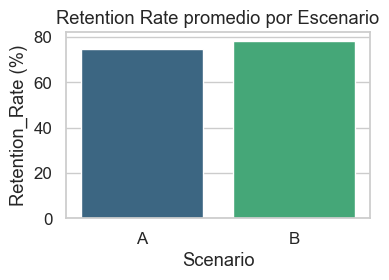

In [9]:
check = dashboard_df.groupby("Scenario")["Retention_Rate"].mean().reset_index()
plt.figure(figsize=(4,3))
sns.barplot(data=check, x="Scenario", y="Retention_Rate", palette="viridis")
plt.title("Retention Rate promedio por Escenario")
plt.ylabel("Retention_Rate (%)")
savefig("fig/retention_rate_promedio_A_vs_B.png")

La simulación muestra que al aplicar estrategias de intervención (Escenario B) la tasa promedio de retención aumenta en 5 puntos porcentuales respecto a la situación actual (Escenario A). Esto sugiere que implementar mejoras en el seguimiento y apoyo a los participantes podría tener un impacto real y positivo en la continuidad de los programas de salud mental.”

In [10]:
DATA_PATH = "Data/dashboard_dataset.csv"  
df = pd.read_csv(DATA_PATH)

# Resumen inicial
n_rows, n_cols = df.shape
print(f"Registros: {n_rows:,} | Columnas: {n_cols}")
display(df.head(3))
display(df.info())

Registros: 9,782 | Columnas: 9


,Scenario,Retention_Rate,Age_group,Gender,Country,Mental_Health_Condition,Severity_filled,Consultation_History,lifestyle_risk
0,A,100.0,18-29,Female,Australia,No,High,No,0
1,A,100.0,18-29,Female,Australia,No,High,No,1
2,A,100.0,18-29,Female,Australia,No,High,Yes,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9782 entries, 0 to 9781
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Scenario                 9782 non-null   object 
 1   Retention_Rate           9782 non-null   float64
 2   Age_group                9782 non-null   object 
 3   Gender                   9782 non-null   object 
 4   Country                  9782 non-null   object 
 5   Mental_Health_Condition  9782 non-null   object 
 6   Severity_filled          9782 non-null   object 
 7   Consultation_History     9782 non-null   object 
 8   lifestyle_risk           9782 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 687.9+ KB


None

<h2 style="color: #6A5ACD;">
8. Dataset agregado para Tableau: abandono + IC95% por escenario y subgrupos
</h2>

In [11]:
# --- Dataset agregado para Tableau (dos versiones: oficial y extendida) 

# Rutas de entrada/salida
INPUT_PATH = Path("Data/dashboard_dataset.csv")
OUTPUT_OFFICIAL = Path("Data/dashboard_dataset_aggregated_official.csv")
OUTPUT_EXTENDED = Path("Data/dashboard_dataset_aggregated_extended.csv")

# 1) Cargar dataset base
df = pd.read_csv(INPUT_PATH)

# 2) Crear métrica de abandono en %
ret = df["Retention_Rate"]
if ret.max() <= 1.0:  # por si estaba en [0,1]
    ret = ret * 100
df["Dropout"] = (100.0 - ret).clip(lower=0, upper=100)

# 3) Función auxiliar para IC95%
def summarize(group):
    mean = group.mean()
    n = group.count()
    std = group.std(ddof=1)
    se = std / np.sqrt(n) if n > 1 else 0
    ci_low = mean - 1.96 * se
    ci_high = mean + 1.96 * se
    return pd.Series({
        "Mean_dropout": mean,
        "CI_low": ci_low,
        "CI_high": ci_high,
        "n": n
    })

# --- Versión OFICIAL ---
group_cols_official = ["Scenario", "Age_group", "Gender", "Severity_filled"]

agg_official = (
    df.groupby(group_cols_official)["Dropout"]
      .apply(summarize)
      .reset_index()
)

agg_official.to_csv(OUTPUT_OFFICIAL, index=False)

# --- Versión EXTENDIDA ---
group_cols_extended = ["Scenario", "Age_group", "Gender", "Severity_filled", "Mental_Health_Condition"]

agg_extended = (
    df.groupby(group_cols_extended)["Dropout"]
      .apply(summarize)
      .reset_index()
)

agg_extended.to_csv(OUTPUT_EXTENDED, index=False)

print(f"Dataset oficial guardado en: {OUTPUT_OFFICIAL.resolve()}")
print(f"Dataset extendido guardado en: {OUTPUT_EXTENDED.resolve()}")

display(agg_official.head())
display(agg_extended.head())


Dataset oficial guardado en: C:\Users\acbon\Documents\Master Data Science UCM\TFM_2\Data\dashboard_dataset_aggregated_official.csv
Dataset extendido guardado en: C:\Users\acbon\Documents\Master Data Science UCM\TFM_2\Data\dashboard_dataset_aggregated_extended.csv


,Scenario,Age_group,Gender,Severity_filled,level_4,Dropout
0,A,18-29,Female,High,Mean_dropout,25.000000
1,A,18-29,Female,High,CI_low,15.200000
2,A,18-29,Female,High,CI_high,34.800000
3,A,18-29,Female,High,n,76.000000
4,A,18-29,Female,Low,Mean_dropout,23.943662


,Scenario,Age_group,Gender,Severity_filled,Mental_Health_Condition,level_5,Dropout
0,A,18-29,Female,High,No,Mean_dropout,0.0
1,A,18-29,Female,High,No,CI_low,0.0
2,A,18-29,Female,High,No,CI_high,0.0
3,A,18-29,Female,High,No,n,36.0
4,A,18-29,Female,High,Yes,Mean_dropout,47.5


In [12]:
# --- Crear diccionario de variables para datasets agregados ---

# Definición manual del diccionario de variables
diccionario = [
    {"Variable": "Scenario", 
     "Descripción": "Escenario de simulación (Control, A, B, etc.)", 
     "Tipo": "Categorical"},
    
    {"Variable": "Age_group", 
     "Descripción": "Grupo de edad del participante (ej. 18-29, 30-44, etc.)", 
     "Tipo": "Categorical"},
    
    {"Variable": "Gender", 
     "Descripción": "Género del participante (Male, Female)", 
     "Tipo": "Categorical"},
    
    {"Variable": "Severity_filled", 
     "Descripción": "Nivel de severidad de la condición de salud mental (Low, Medium, High)", 
     "Tipo": "Categorical"},
    
    {"Variable": "Mental_Health_Condition", 
     "Descripción": "Presencia de condición de salud mental diagnosticada (Yes, No). Solo en dataset extendido.", 
     "Tipo": "Categorical"},
    
    {"Variable": "Mean_dropout", 
     "Descripción": "Promedio de abandono (%) en el grupo", 
     "Tipo": "Numeric (float)"},
    
    {"Variable": "CI_low", 
     "Descripción": "Límite inferior del intervalo de confianza 95% para abandono (%)", 
     "Tipo": "Numeric (float)"},
    
    {"Variable": "CI_high", 
     "Descripción": "Límite superior del intervalo de confianza 95% para abandono (%)", 
     "Tipo": "Numeric (float)"},
    
    {"Variable": "n", 
     "Descripción": "Número de observaciones en el grupo", 
     "Tipo": "Numeric (integer)"}
]

# Convertir a DataFrame
diccionario_df = pd.DataFrame(diccionario)

# Guardar en CSV
OUTPUT_DICT = Path("Data/dashboard_dataset_dictionary.csv")
diccionario_df.to_csv(OUTPUT_DICT, index=False)

print(f"Diccionario de variables guardado en: {OUTPUT_DICT.resolve()}")
display(diccionario_df)


Diccionario de variables guardado en: C:\Users\acbon\Documents\Master Data Science UCM\TFM_2\Data\dashboard_dataset_dictionary.csv


,Variable,Descripción,Tipo
0,Scenario,"Escenario de simulación (Control, A, B, etc.)",Categorical
1,Age_group,"Grupo de edad del participante (ej. 18-29, 30-...",Categorical
2,Gender,"Género del participante (Male, Female)",Categorical
3,Severity_filled,Nivel de severidad de la condición de salud me...,Categorical
4,Mental_Health_Condition,Presencia de condición de salud mental diagnos...,Categorical
5,Mean_dropout,Promedio de abandono (%) en el grupo,Numeric (float)
6,CI_low,Límite inferior del intervalo de confianza 95%...,Numeric (float)
7,CI_high,Límite superior del intervalo de confianza 95%...,Numeric (float)
8,n,Número de observaciones en el grupo,Numeric (integer)
